# Malnutrition Classification System


In [ ]:
%pip install -q tqdm numpy pandas matplotlib seaborn tensorflow scikit-learn

# Core
import os, io, json, random, shutil, zipfile, time, math, pathlib
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings; warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Metrics
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_fscore_support, roc_curve, auc)

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
TensorFlow: 2.19.0
GPU: []


2. Data Acquisition

In [ ]:
import os
import shutil
import random

# Config
DATA_DIR = "../data"
TEST_DIR = os.path.join(DATA_DIR, "test")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
CLASSES = ["MALNUTRITION", "NUTRITION"]
VAL_SPLIT = 0.2
RANDOM_SEED = 42

random.seed(RANDOM_SEED)

def safe_copy(src, dst):
    """Copy a file without overwriting existing files."""
    if not os.path.exists(dst):
        shutil.copy2(src, dst)

# Ensure target directories exist
for cls in CLASSES:
    os.makedirs(os.path.join(TRAIN_DIR, cls), exist_ok=True)
    os.makedirs(os.path.join(VAL_DIR, cls), exist_ok=True)

# Move test images into train (copy to preserve original if needed)
for cls in CLASSES:
    src_dir = os.path.join(TEST_DIR, cls)
    dst_dir = os.path.join(TRAIN_DIR, cls)
    if os.path.exists(src_dir):
        for fname in os.listdir(src_dir):
            safe_copy(os.path.join(src_dir, fname), os.path.join(dst_dir, fname))

# Split train into train/val without losing original files
for cls in CLASSES:
    cls_train_dir = os.path.join(TRAIN_DIR, cls)
    cls_val_dir = os.path.join(VAL_DIR, cls)

    images = [f for f in os.listdir(cls_train_dir) if os.path.isfile(os.path.join(cls_train_dir, f))]
    random.shuffle(images)
    val_count = int(len(images) * VAL_SPLIT)

    val_images = images[:val_count]
    for fname in val_images:
        src_path = os.path.join(cls_train_dir, fname)
        dst_path = os.path.join(cls_val_dir, fname)
        safe_copy(src_path, dst_path)

print("Dataset restructured and split without overwriting original data.")


Dataset restructured and split without overwriting original data.


In [ ]:
# Define data paths
TRAIN_DIR = "../data/train"
TEST_DIR = "../data/test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Explore dataset structure
def explore_dataset(data_dir):
    """Explore the dataset structure and count images."""
    classes = ['MALNUTRITION', 'NUTRITION']
    data_info = {}
    
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        if os.path.exists(class_path):
            image_count = len([f for f in os.listdir(class_path) 
                             if f.lower().endswith(('.jpeg', '.jpg', '.png'))])
            data_info[class_name] = image_count
        else:
            data_info[class_name] = 0
    
    return data_info

# Explore training and test data
print("Dataset:")
print("="*50)

train_info = explore_dataset(TRAIN_DIR)
test_info = explore_dataset(TEST_DIR)

print(f"Training Data:")
for class_name, count in train_info.items():
    print(f"  {class_name}: {count} images")

print(f"\nTest Data:")
for class_name, count in test_info.items():
    print(f"  {class_name}: {count} images")

print(f"\nTotal Training Images: {sum(train_info.values())}")
print(f"Total Test Images: {sum(test_info.values())}")

# Calculate class distribution
total_train = sum(train_info.values())
if total_train > 0:
    print(f"\nClass Distribution (Training):")
    for class_name, count in train_info.items():
        print(f"  {class_name}: {percentage:.1f}%")

Dataset:
Training Data:
  MALNUTRITION: 71 images
  NUTRITION: 71 images

Test Data:
  MALNUTRITION: 0 images
  NUTRITION: 0 images

Total Training Images: 142
Total Test Images: 0

Class Distribution (Training):
  MALNUTRITION: 100.0%
  NUTRITION: 100.0%


In [ ]:
%pip install tensorflow

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "../data/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    "../data/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Note: you may need to restart the kernel to use updated packages.
Found 661 images belonging to 2 classes.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Found 1348 images belonging to 2 classes.


Model Testing

In [ ]:
%pip install tensorflow

import tensorflow as tf

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss")
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

print("Model training complete.")


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\USER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4422 - loss: 0.8096

21/21 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.6248 - loss: 0.6407 - val_accuracy: 0.8754 - val_loss: 0.3589 - learning_rate: 0.0010
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9078 - loss: 0.3139

21/21 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.9107 - loss: 0.2918 - val_accuracy: 0.9280 - val_loss: 0.2288 - learning_rate: 0.0010
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9387 - loss: 0.2052

21/21 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - accuracy: 0.9334 - loss: 0.2088 - val_accuracy: 0.9399 - val_loss: 0.1864 - learning_rate: 0.0010
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9388 - loss: 0.1745

21/21 ━━━━━━━━━━━━━━━━━━━━ 104s 5s/step - accuracy: 0.9410 - loss: 0.1718 - val_accuracy: 0.9451 - val_loss: 0.1681 - learning_rate: 0.0010
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9327 - loss: 0.1679

21/21 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step - accuracy: 0.9455 - loss: 0.1527 - val_accuracy: 0.9473 - val_loss: 0.1579 - learning_rate: 0.0010
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9557 - loss: 0.1322

21/21 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.9546 - loss: 0.1333 - val_accuracy: 0.9473 - val_loss: 0.1478 - learning_rate: 0.0010
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9579 - loss: 0.1168

21/21 ━━━━━━━━━━━━━━━━━━━━ 113s 6s/step - accuracy: 0.9546 - loss: 0.1238 - val_accuracy: 0.9481 - val_loss: 0.1441 - learning_rate: 0.0010
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9734 - loss: 0.1038

21/21 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.9652 - loss: 0.1112 - val_accuracy: 0.9510 - val_loss: 0.1385 - learning_rate: 0.0010
Epoch 9/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9844 - loss: 0.1010

21/21 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.9758 - loss: 0.1004 - val_accuracy: 0.9503 - val_loss: 0.1353 - learning_rate: 0.0010
Epoch 10/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.9773 - loss: 0.0949 - val_accuracy: 0.9496 - val_loss: 0.1358 - learning_rate: 0.0010
Epoch 11/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9769 - loss: 0.0843

21/21 ━━━━━━━━━━━━━━━━━━━━ 6142s 307s/step - accuracy: 0.9758 - loss: 0.0869 - val_accuracy: 0.9503 - val_loss: 0.1306 - learning_rate: 0.0010
Epoch 12/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9854 - loss: 0.0759

21/21 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.9803 - loss: 0.0809 - val_accuracy: 0.9510 - val_loss: 0.1290 - learning_rate: 0.0010
Epoch 13/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9799 - loss: 0.0751

21/21 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.9773 - loss: 0.0757 - val_accuracy: 0.9533 - val_loss: 0.1282 - learning_rate: 0.0010
Epoch 14/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9848 - loss: 0.0657

21/21 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.9818 - loss: 0.0710 - val_accuracy: 0.9518 - val_loss: 0.1273 - learning_rate: 0.0010
Epoch 15/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.9894 - loss: 0.0672 - val_accuracy: 0.9496 - val_loss: 0.1300 - learning_rate: 0.0010
✅ Model training complete.


Plotting

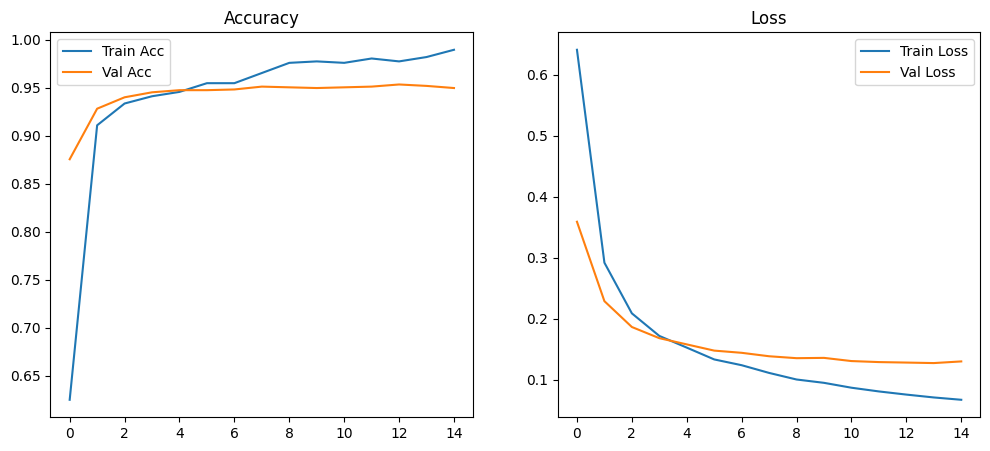

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")

    plt.show()

plot_history(history)


Model retraining

In [ ]:
import time

def watch_and_retrain(train_dir, val_dir, interval=300):
    prev_train_count = sum(len(os.listdir(os.path.join(train_dir, cls))) for cls in ["MALNUTRITION", "NUTRITION"])
    prev_val_count = sum(len(os.listdir(os.path.join(val_dir, cls))) for cls in ["MALNUTRITION", "NUTRITION"])

    while True:
        time.sleep(interval)
        curr_train_count = sum(len(os.listdir(os.path.join(train_dir, cls))) for cls in ["MALNUTRITION", "NUTRITION"])
        curr_val_count = sum(len(os.listdir(os.path.join(val_dir, cls))) for cls in ["MALNUTRITION", "NUTRITION"])

        if curr_train_count != prev_train_count or curr_val_count != prev_val_count:
            print("New data detected. Retraining model...")
            history = model.fit(
                train_generator,
                validation_data=val_generator,
                epochs=5,
                callbacks=[checkpoint, early_stop, reduce_lr]
            )
            print(" Retraining complete.")
            prev_train_count = curr_train_count
            prev_val_count = curr_val_count
